<a href="https://colab.research.google.com/github/duarte3333/Machine_Learning/blob/main/task1_imageanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [153]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
import tensorflow.keras.backend as K

################# PRE PROCESSING ####################
def load_data():
    """ Load the training and test data. """
    #2352 elements each image: 2352 = pixels x pixels x 3 (RGB)
    X = np.load('Xtrain_Classification1.npy') #6254 x 2352. 2352 = pixels x pixels x 3 (RGB). Training set is inbalanced, different number of samples for each class
    y = np.load('ytrain_Classification1.npy') #6254. 1D vector
    X_t = np.load('Xtest_Classification1.npy') #1764 x 2352. Has data from two distinct sources
    return X, y, X_t

def preprocess_data(X, X_t):
    """ This function scale the training data to be in the range [0, 1]
    and the data type to float32 for numerical stability """
    Xs = (X).astype('float32') / np.max(X) #Scale down data [0,1]
    Xs_test = (X_t).astype('float32') / np.max(X)
    return Xs, Xs_test

def encode_data(y, Xs, y_test, Xs_test):
    """ Enconde data function """
    train_labels = keras.utils.to_categorical(y,num_classes=2) #One-hot enconding: 6254 x 2 matrix that is 0 or 1 depending on class
    test_labels = keras.utils.to_categorical(y_test,num_classes=2)
    train_images = np.reshape(Xs, (len(Xs[:,0]),28,28,3)) #4D array. number of images x width x height x color
    test_images = np.reshape(Xs_test, (len(Xs_test[:,0]), 28, 28, 3))
    return train_labels, train_images, test_images, test_labels

def shuffle_data(train_images, train_labels):
    permutation = np.random.permutation(len(train_images))
    train_images_s = train_images[permutation]
    train_labels_s = train_labels[permutation]
    return train_images_s, train_labels_s

def split_data(train_images_s, train_labels_s):
    X_train, X_validation, y_train, y_validation = train_test_split(train_images_s, train_labels_s, test_size=0.2)
    print("X_train: ", X_train.shape)
    print("y_train: ", y_train.shape)
    return X_train, X_validation, y_train, y_validation

def plot_images(number_images,X_train):
  '''Plot a user defined number of images from X_train. Only really works for 10 images'''
  number_images = 10
  plt.figure(figsize=(12, 6))
  for i in range(number_images):
      plt.subplot(2, 5, i + 1)
      plt.imshow(X_train[i])
      plt.title(f"Image {i+1}")
      plt.axis('off')
  plt.tight_layout()
  plt.show()

######################## NEURAL NETWORK #####################################

#Building MLP neural network, Sequential (linear stack of Layers); kernel size 3 by 3 is normal in image data
#padding keeps images in the same size; poolsize and strides -> Check notes on notion on maxpooling
def MLP_NN():
    MLP = keras.Sequential([
        keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation = 'relu', padding= 'same', input_shape = (28,28,3)),
        keras.layers.MaxPool2D(pool_size =(2,2), strides=2),
        keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation = 'relu', padding='same'),
        keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
        keras.layers.Flatten(), #Flatten is always needed before using fully connected layer (Dense) for output
        keras.layers.Dense(units=2, activation='softmax')
    ])
    #MLP.summary() #See created neural network
    return MLP

def Convolution_NN(): #another model
    cnn_model1 = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3),1, activation='relu', input_shape=(28, 28, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3),1, activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3),1, activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(2,activation='softmax')
    ])
    return cnn_model1

def Convolution_NN_3(): 
    cnn_model2 = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu',padding='same',input_shape=(28, 28, 3)),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu',padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.7),
    keras.layers.Dense(2, activation='softmax')
    ])
    return cnn_model2

def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        pt = y_pred * y_true + (1 - y_pred) * (1 - y_true) # Get the "modulated" probabilities 
        return -K.sum(alpha * K.pow(1.0 - pt, gamma) * K.log(pt + K.epsilon()))
    return focal_loss_fixed

def f1_score(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')  # Cast y_true to float32
    y_pred = K.cast(K.round(y_pred), 'float32')  # Cast y_pred to float32
    
    # Compute precision, recall
    precision = K.sum(y_true * y_pred) / (K.sum(y_pred) + K.epsilon())
    recall = K.sum(y_true * y_pred) / (K.sum(y_true) + K.epsilon())

    # Compute F1 score
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_score

def Compile_MLP_categorical_crossentropy(MLP):
    MLP.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=[f1_score]) #accuracy only used for balanced data

def Compile_MLP_focal_loss(MLP):
    MLP.compile(optimizer=Adam(learning_rate=0.0001), loss=focal_loss(), metrics=[f1_score])
    
def Compile_MLP_binary_crossentropy(MLP):
    MLP.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=[f1_score])

def class_weights(y_train): #classes less frequent get higher weights in training model
    weights = class_weight.compute_class_weight('balanced', classes = np.unique(y_train), y = y_train) #compute weights based on class frequencies
    class_weights = {0: weights[0], 1:weights[1]} #stored in dictionary
    return class_weights

def class_weights(y_train):
    y_train_int = tf.argmax(y_train, axis=1)
    y_train_int_np = y_train_int.numpy()
    weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_int_np), y=y_train_int_np)
    class_weights = {i: weights[i] for i in range(len(weights))}
    return class_weights

def train_model(MLP, X_train, y_train, X_validation, y_validation, in_verbose):
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True) #Patince is the number of epochs whithout improvements
    history = MLP.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                   batch_size=512, epochs=50, shuffle=True, verbose=in_verbose, callbacks=[early_stop])
                   #class_weight=class_weights(y_train))
    return history

######################## RESULTS ############################

def make_predictions(MLP):
    predictions = MLP.predict(x = test_images, batch_size = 200, verbose=0) #Returns probability of each class
    rounded_predictions= np.argmax(predictions, axis=-1) #Rounds it to 0 or 1
    return rounded_predictions
    
def plot(history):#Plot loss evolution in each epoch for training and validation set
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.plot(history.history['f1_score'], 'g', label='Training f1 score')
    plt.plot(history.history['val_f1_score'], 'r', label='Validation f1 score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('Training and validation f1 score')
    plt.legend()
    plt.show()
    
def check_imbalance(MLP):
    rounded_predictions = make_predictions(MLP) #Make predictions
    cont_0 = 0
    for i in rounded_predictions: #Visualize imbalance in training data
        if i == 0:
            cont_0 += 1
    print(cont_0, len(test_images[:,0])-cont_0) #Big difference between classes due to imbalanced training set

def check_results(history):
    plot(history)
    print("Train - Mean loss: ", (history.history['loss'][-1]))
    print("Test  - Mean Val loss: ", np.mean(history.history['val_loss'][-1]))
    print("Train - Mean F1 Score: ", np.mean(history.history['f1_score']))
    print("Test - Mean Val F1 Score: ", np.mean(history.history['val_f1_score']))
    
    
X, y, X_t = load_data()
Xs, Xs_test = preprocess_data(X, X_t)
X_train, X_validation, y_train, y_validation = split_data(Xs, y)
X_train_shuffle, y_train_shuffle = shuffle_data(X_train, y_train)
train_labels, train_images, test_images, test_labels = encode_data(y_train_shuffle, X_train_shuffle, y_validation, X_validation)
#plot_images(10, X_train)

X_train:  (5003, 2352)
y_train:  (5003,)


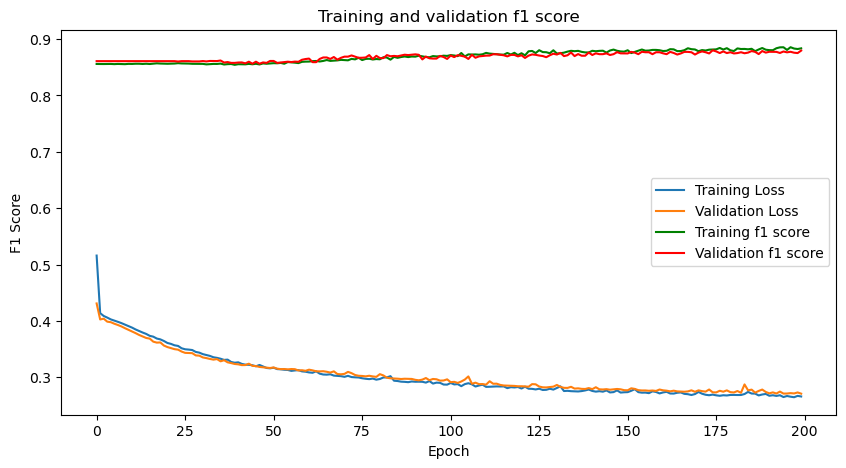

Train - Mean loss:  0.265912801027298
Test  - Mean Val loss:  0.2709096372127533
Train - Mean F1 Score:  0.8692902058362961
Test - Mean Val F1 Score:  0.8685850486159324
1181 70


In [144]:
########## FIRST APPROACH - MLP with imbalanced data ###################

#Compiled with categorical_crossentropy
NN_model = MLP_NN()
Compile_MLP_categorical_crossentropy(NN_model)
history = train_model(NN_model, train_images, train_labels, test_images, test_labels, 0)
check_results(history)
check_imbalance(NN_model)

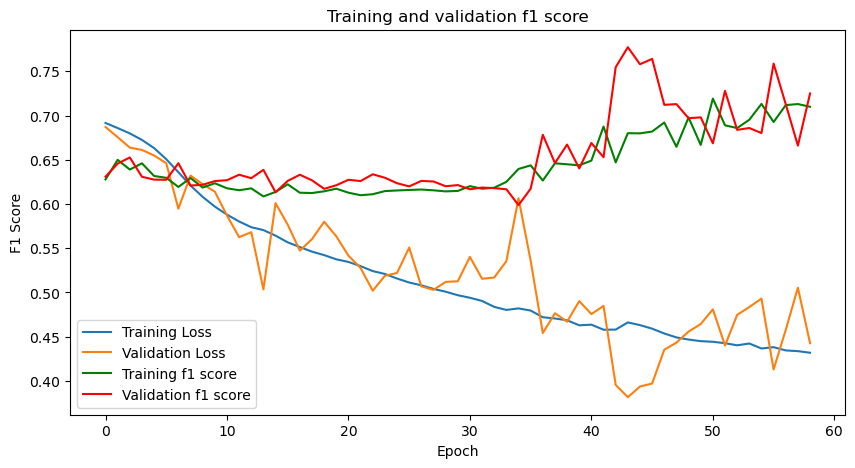

Train - Mean loss:  0.43184250593185425
Test  - Mean Val loss:  0.4426042139530182
Train - Mean F1 Score:  0.6442667690374083
Test - Mean Val F1 Score:  0.6554723159741547
914 337


In [127]:
NN_model_2 = Convolution_NN()
Compile_MLP_categorical_crossentropy(NN_model_2)
history = train_model(NN_model_2, train_images, train_labels, test_images, test_labels, 0)
check_results(history)
check_imbalance(NN_model_2)

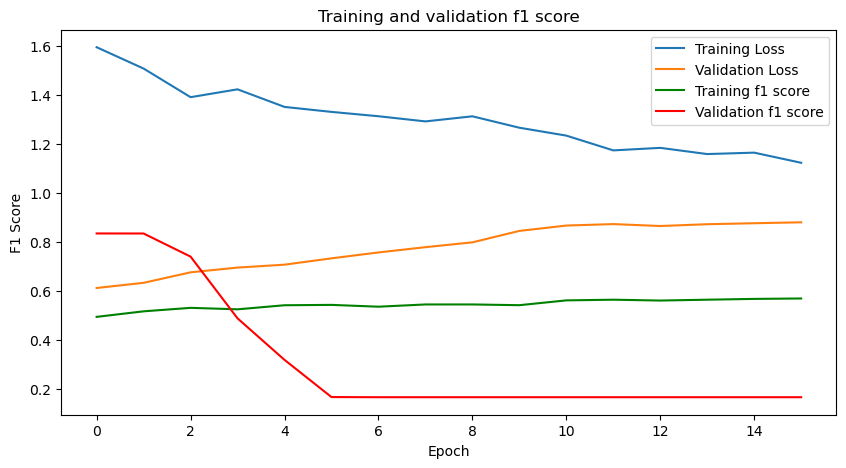

Train - Mean loss:  1.1225582361221313
Test  - Mean Val loss:  0.8796833753585815
Train - Mean F1 Score:  0.543728843331337
Test - Mean Val F1 Score:  0.31490926444530487
1251 0


In [139]:
NN_model_3 = Convolution_NN_3()
Compile_MLP_categorical_crossentropy(NN_model_3)
history = train_model(NN_model_3, train_images, train_labels, test_images, test_labels, 0)
check_results(history)
check_imbalance(NN_model_3)

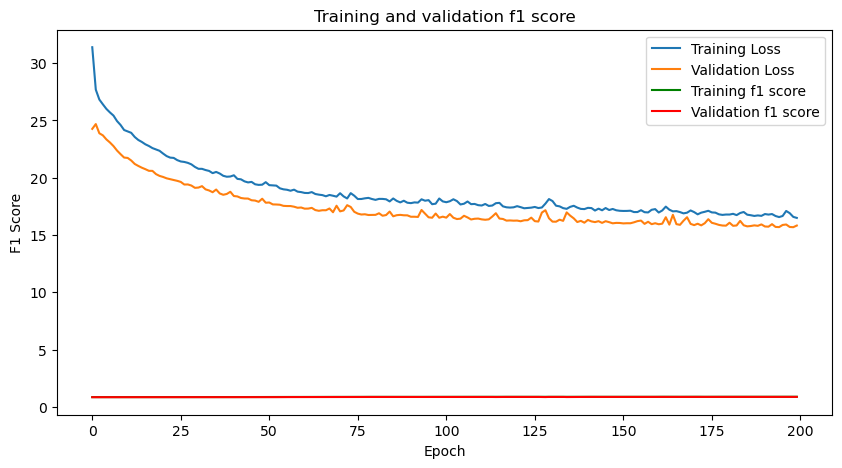

Train - Mean loss:  16.4926815032959
Test  - Mean Val loss:  15.825414657592773
Train - Mean F1 Score:  0.8751004645228386
Test - Mean Val F1 Score:  0.8655098482966423
1150 101


In [152]:
#Compiled with focal loss

# Assign higher weights to the misclassified examples of the minority class
MLP = MLP_NN()
Compile_MLP_focal_loss(MLP)
history = train_model(MLP, train_images, train_labels, test_images, test_labels, 0)
check_results(history)
check_imbalance(MLP)
# Train MLP model, # Note: Try 'SparseCategoricalCrossEntropy' as loss function.

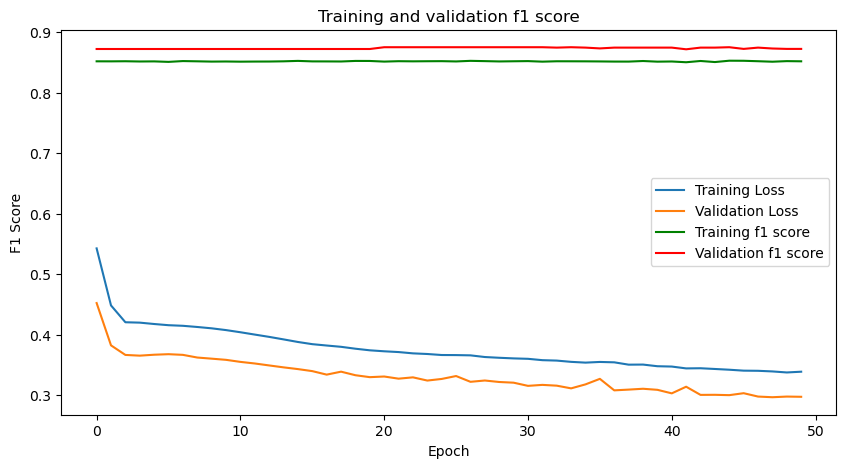

Train - Mean loss:  0.338948130607605
Test  - Mean Val loss:  0.2975061237812042
Train - Mean F1 Score:  0.85155069231987
Test - Mean Val F1 Score:  0.8732641899585724
1244 7


In [154]:
#Compiled with binary crossentropy

MLP = MLP_NN()
Compile_MLP_binary_crossentropy(MLP)
history = train_model(MLP, train_images, train_labels, test_images, test_labels, 0)
check_results(history)
check_imbalance(MLP)

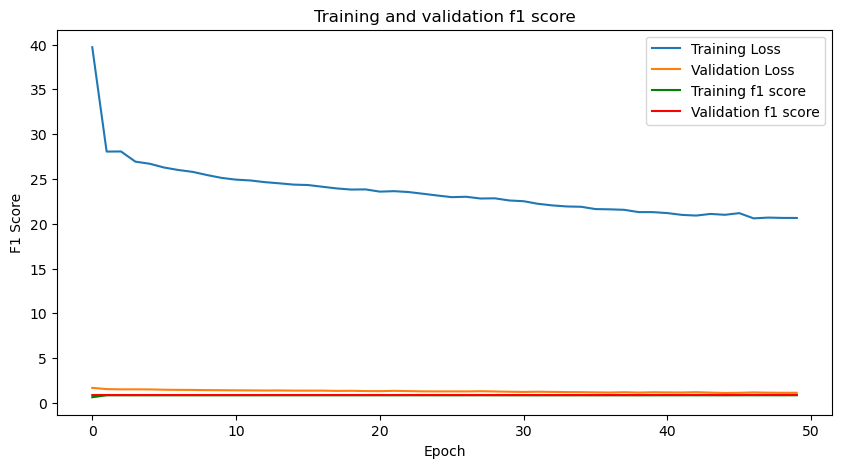

Train - Mean loss:  20.642850875854492
Test  - Mean Val loss:  1.1311646699905396
Train - Mean F1 Score:  0.8468544960021973
Test - Mean Val F1 Score:  0.8813124084472657
1223 28


In [155]:
############### SECOND APPROACH - BALANCED DATA #############

#Create ways to do data augmentation
def train_model_aug(MLP):
    # Data augmentation
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    Compile_MLP_focal_loss(MLP)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Fit the model with data augmentation
    return MLP.fit(
        datagen.flow(train_images, train_labels, batch_size=512),
        steps_per_epoch=len(train_images) / 512,
        epochs=200,
        validation_data=(test_images, test_labels),
        callbacks=[early_stop],
        verbose=0
    )

MLP = MLP_NN()
history = train_model_aug(MLP)
check_results(history)
check_imbalance(MLP)

X_train:  (6817, 28, 28, 3)
y_train:  (6817, 2)


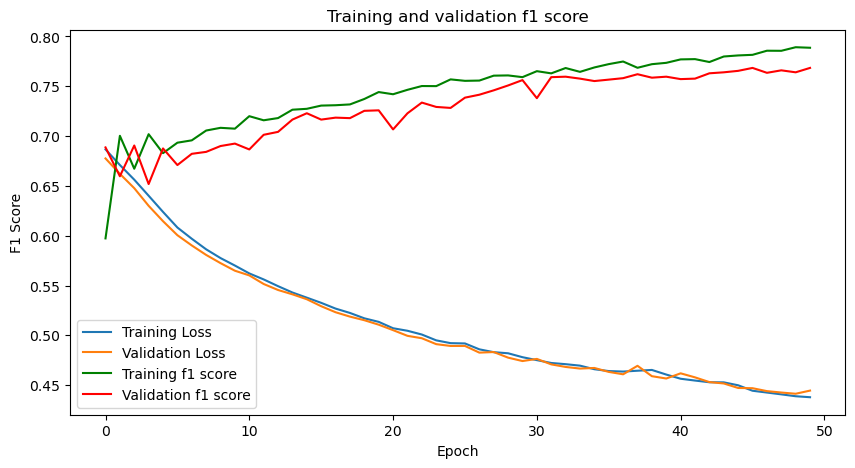

Train - Mean loss:  0.4379461407661438
Test  - Mean Val loss:  0.44459080696105957
Train - Mean F1 Score:  0.7437919437885284
Test - Mean Val F1 Score:  0.72977485537529
729 522


In [158]:
# Synthetic Minority Over-sampling Technique
from imblearn.over_sampling import SMOTE

#It uses SMOTE to oversample the minority class, adjusting the number of samples for each class.
def oversample_data(train_images, train_labels):
    smote = SMOTE(sampling_strategy='auto')
    train_images_reshaped = train_images.reshape(-1, 28*28*3)  # Reshape images for SMOTE
    train_images_oversampled_reshaped, train_labels_oversampled = smote.fit_resample(train_images_reshaped, train_labels)
    train_images_oversampled = train_images_oversampled_reshaped.reshape(-1, 28, 28, 3)  # Reshape back to original shape
    return train_images_oversampled, train_labels_oversampled

train_images_s_oversampled, train_labels_s_oversampled = oversample_data(train_images, train_labels)
train_labels_1, train_images_1, test_images, test_labels = encode_data(train_labels_s_oversampled, train_images_s_oversampled, test_labels, test_images)
X_train, X_validation, y_train, y_validation = split_data(train_images_1, train_labels_1)

MLP_oversampled = MLP_NN()
Compile_MLP_categorical_crossentropy(MLP_oversampled)
history_oversampled = train_model(MLP_oversampled, X_train, y_train, X_validation, y_validation, 0)
check_results(history_oversampled)
check_imbalance(MLP_oversampled)